## Recreating the Master Unit List

#### setup/imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
import sys
sys.path.append("../") # go to parent dir
from plant_part_agg_eia import *
from plant_parts import plant_parts

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

#### defining a table grabbing object

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pt = pudl.output.pudltabl.get_table_meta(pudl_engine)
start_date=None
end_date=None
freq='AS'

In [7]:
from plant_parts import plant_parts

In [8]:
self = CompileTables(pudl_engine, freq='AS', rolling=True)

In [31]:
compiled_plant_parts, parts_df = self.generate_master_unit_list(plant_parts)

beginning the aggregation for generators_eia860
aggregate the parts
beginning the aggregation for generation_eia923
aggregate the parts
beginning the aggregation for mcoe
aggregate the parts
plant
aggregate the parts
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
plant_gen
aggregate the parts
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
plant_unit
denormalize plant_unit
aggregate the parts
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
Converting the dtypes of: None
plant_technology
denormalize plant_technology
aggregate the parts
Converting the dtypes of: None
Converting the dtypes of: None
Converting th

In [11]:
def plot_plant_vs_agg(compiled_plant_parts, field, xy_limits, scale):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for plant_gran, df in compiled_plant_parts.items():
        if plant_gran != 'plant':
            field_plant = field+'_plant'
            field_gran = field+'_'+plant_gran
            try:
                merge_df = compiled_plant_parts['plant'].merge(df, on=['plant_id_eia', 
                                                                       'report_date',
                                                                       'utility_id_eia',
                                                                       'fraction_owned'
                                                                      ], suffixes=('_plant','_' + plant_gran))
                # this is for the try
                merge_df[field_gran]
                #merge_df = merge_df[merge_df['plant_id_eia'] == 3]
                fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
                ax.scatter(merge_df[field_plant],
                           merge_df[field_gran],
                           color='black', alpha='0.1', label=field)
                ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xscale(scale)
                ax.set_yscale(scale)
                ax.set_ylabel(f'{plant_gran} {field}')
                ax.set_xlabel(f'Plant {field}')
                ax.set_title(f"Plant vs {plant_gran}: {field}")
            except KeyError:
                pass

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


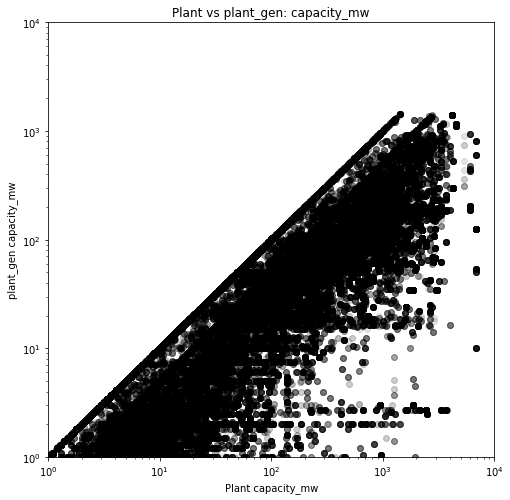

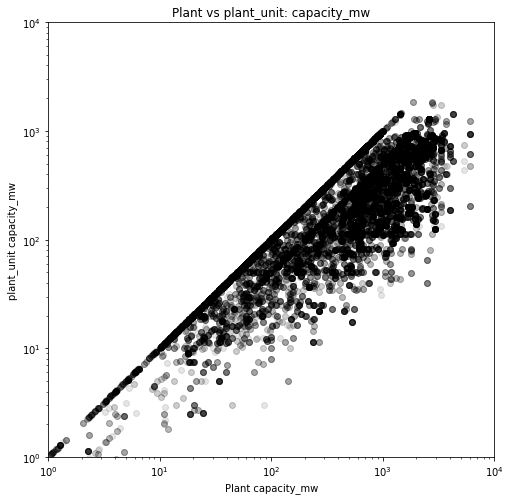

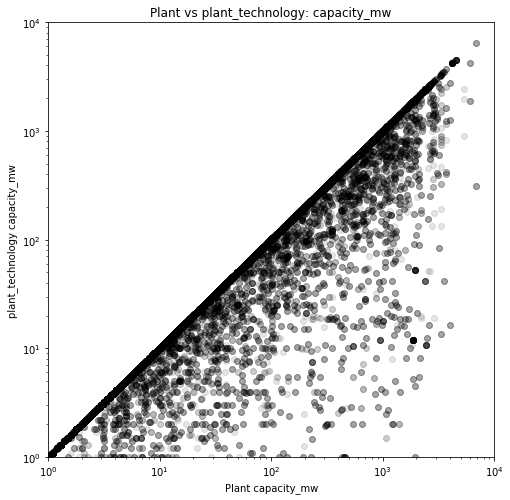

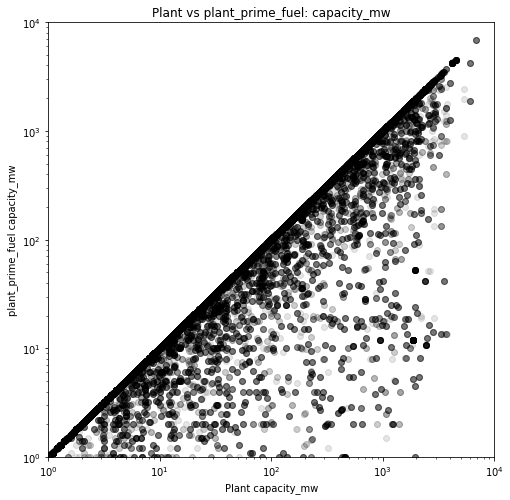

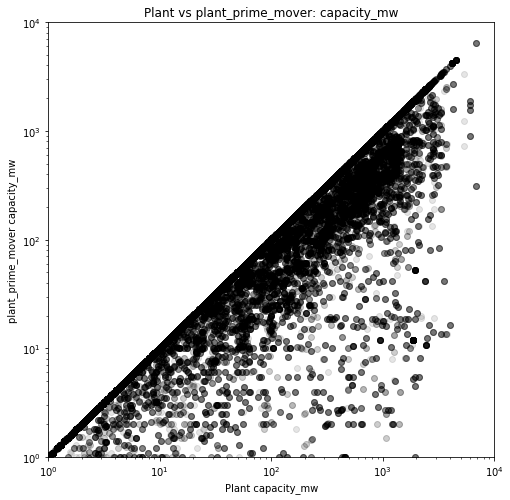

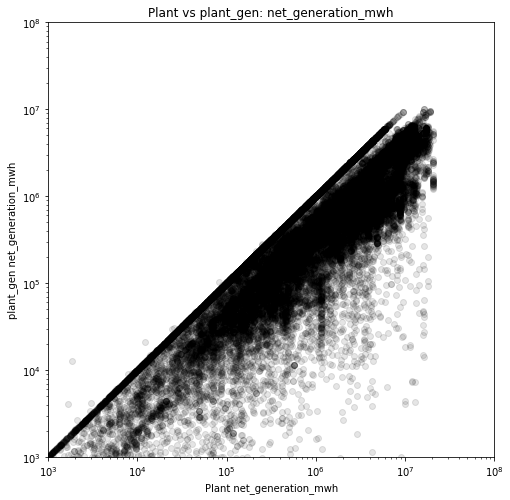

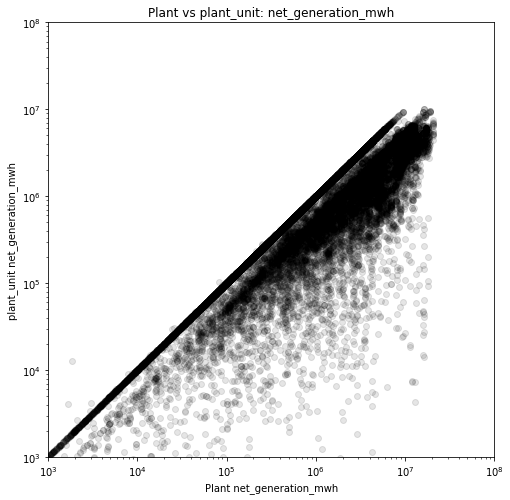

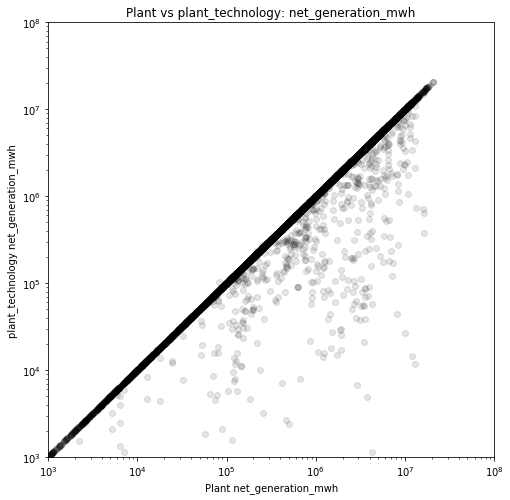

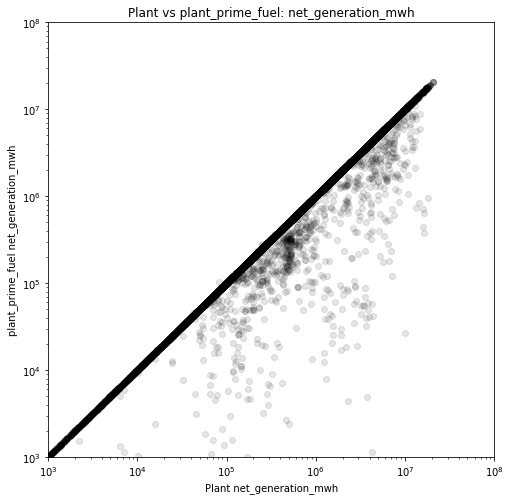

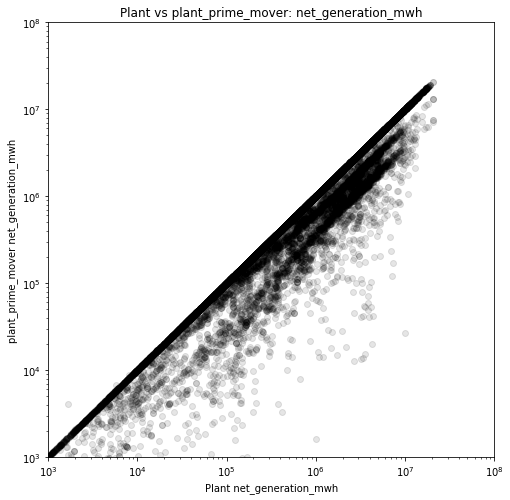

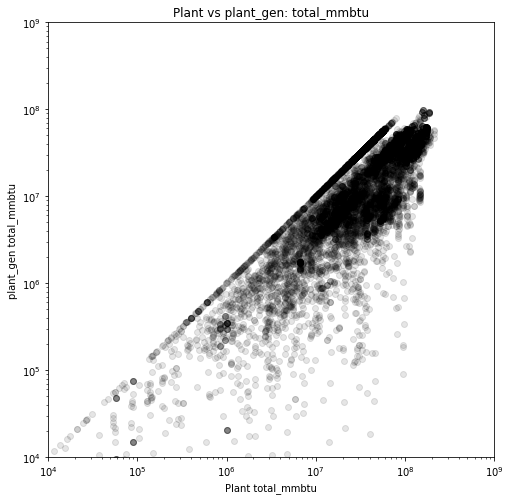

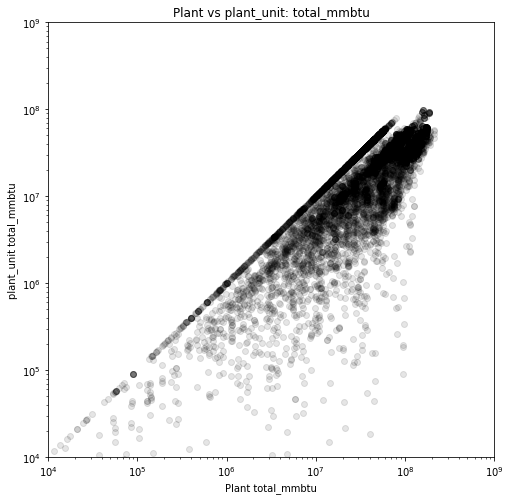

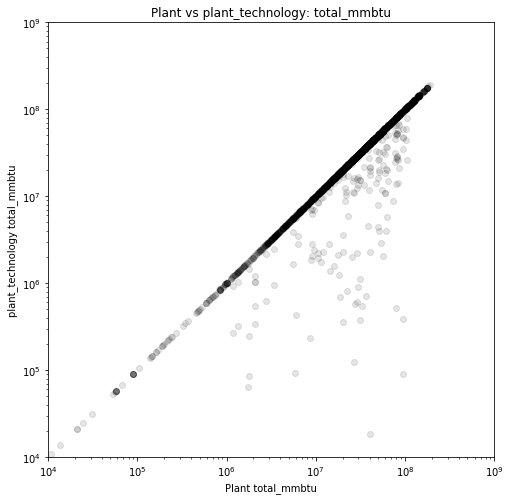

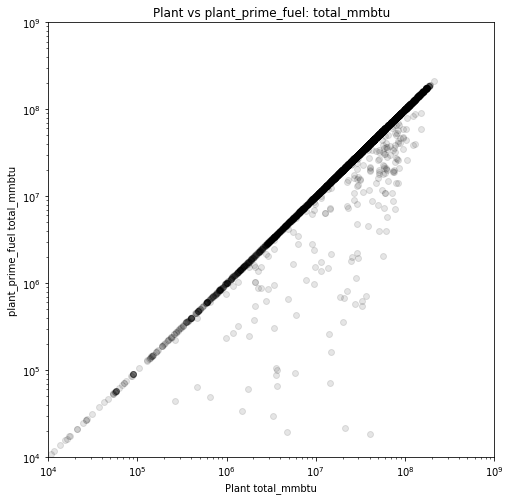

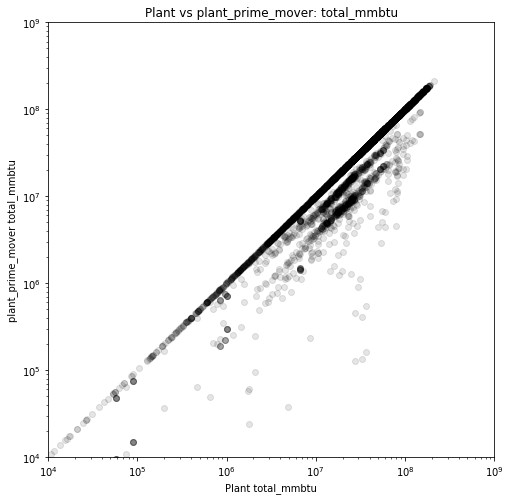

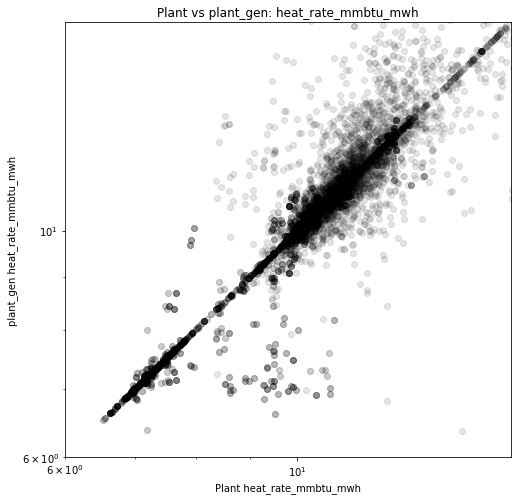

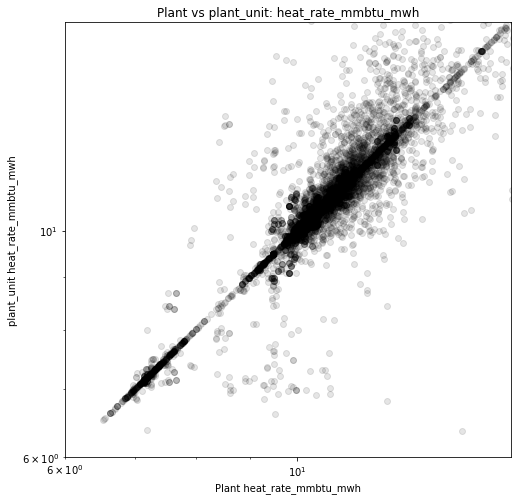

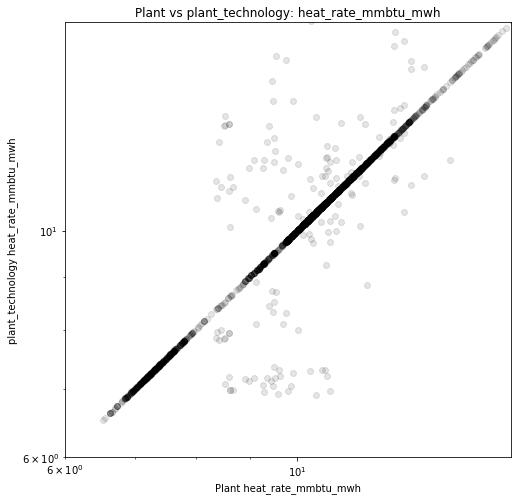

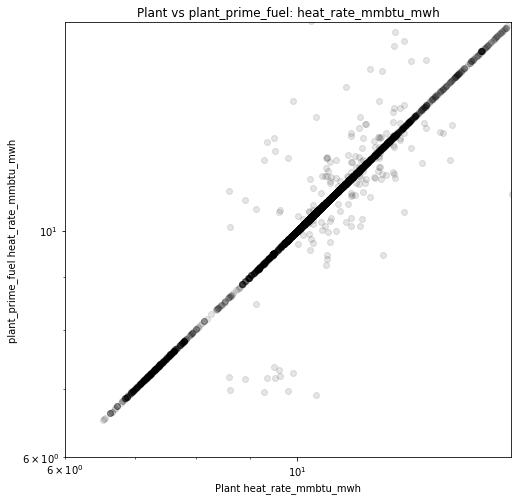

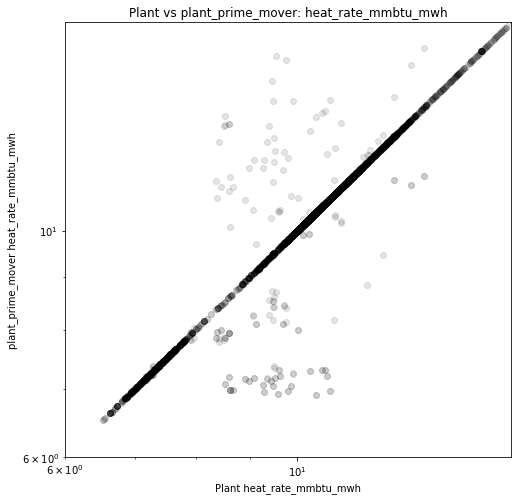

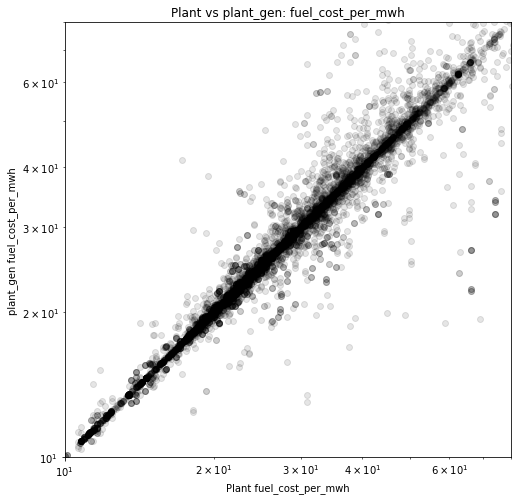

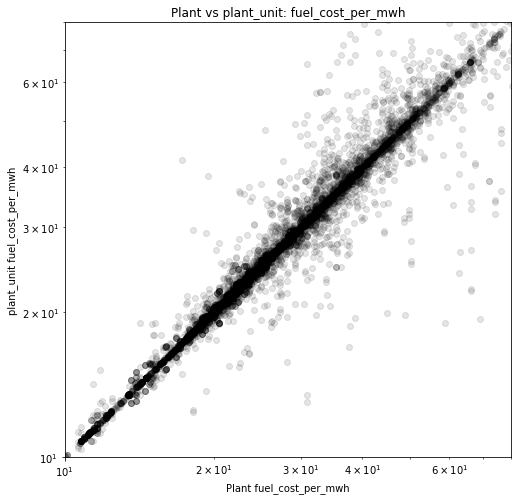

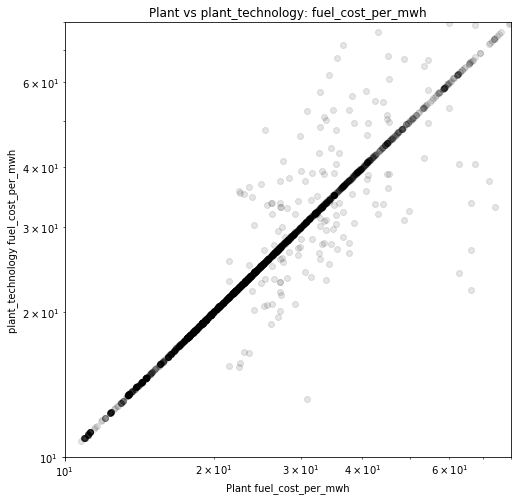

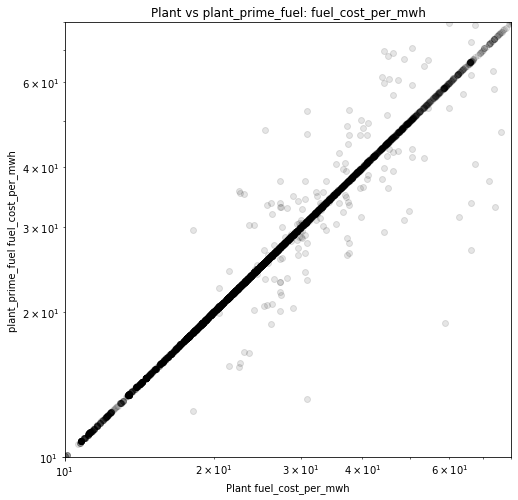

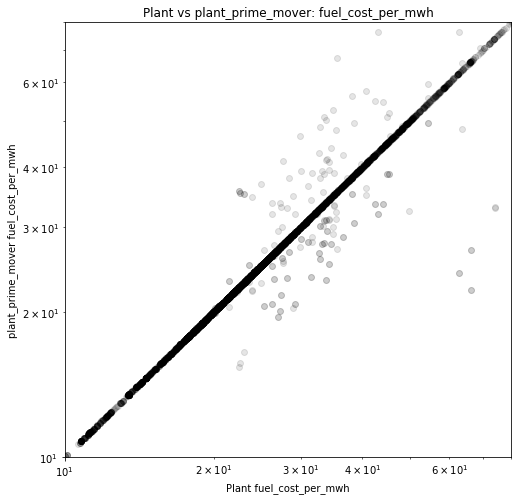

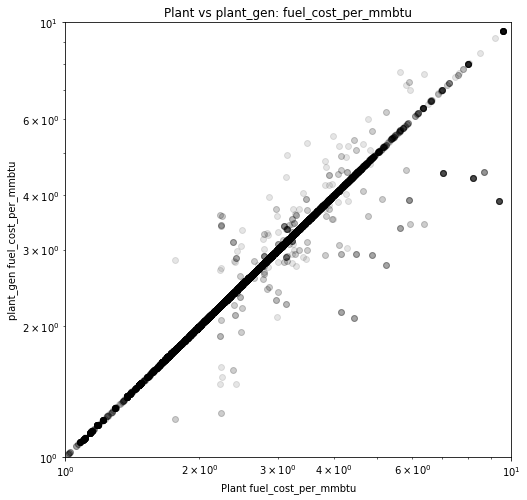

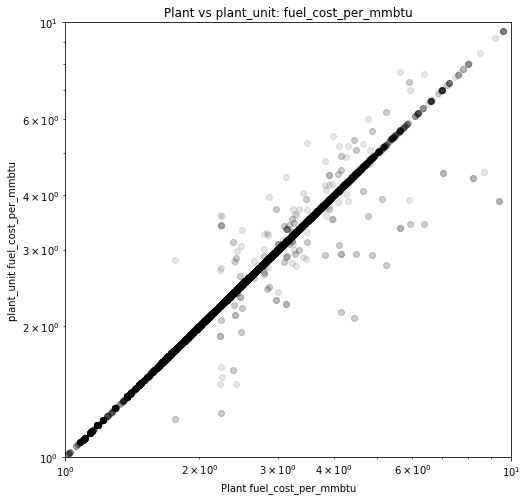

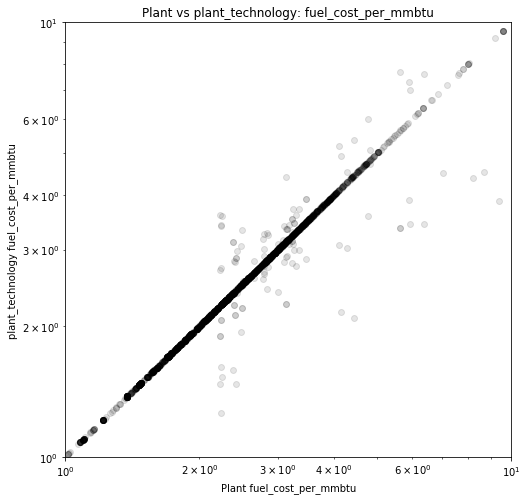

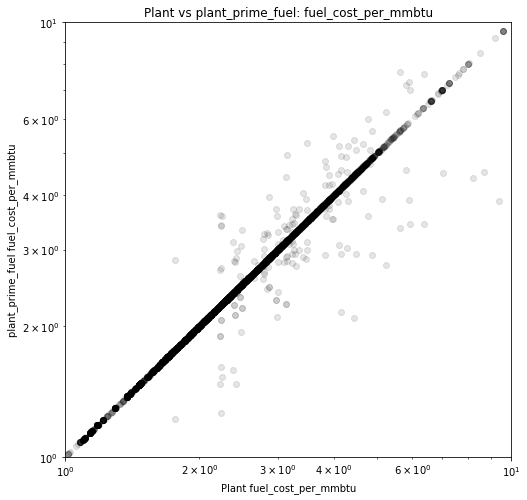

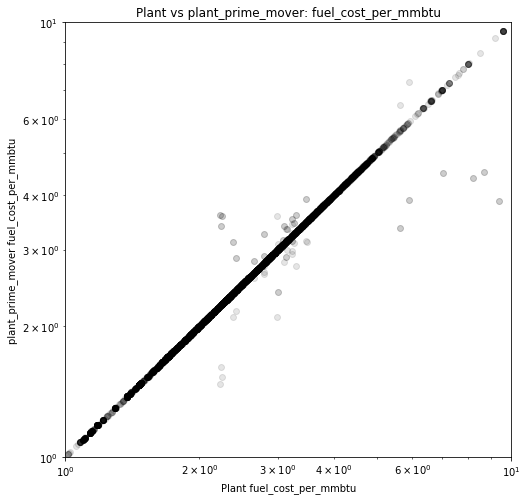

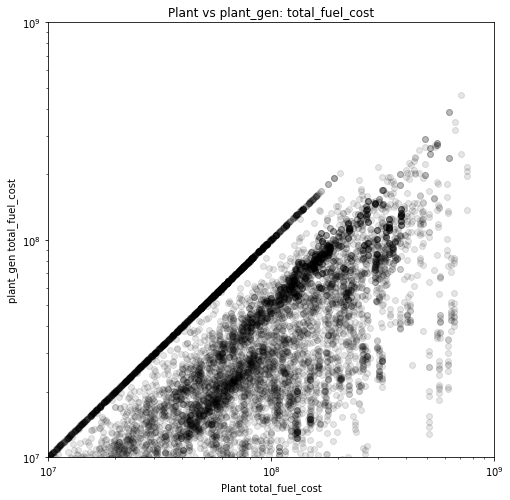

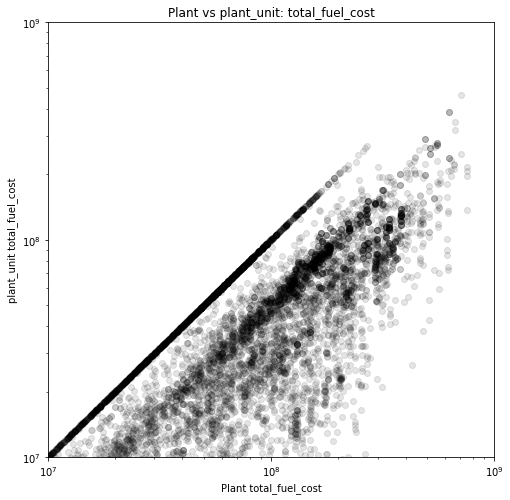

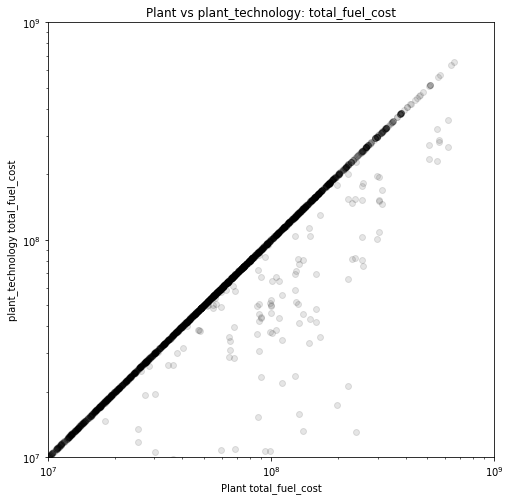

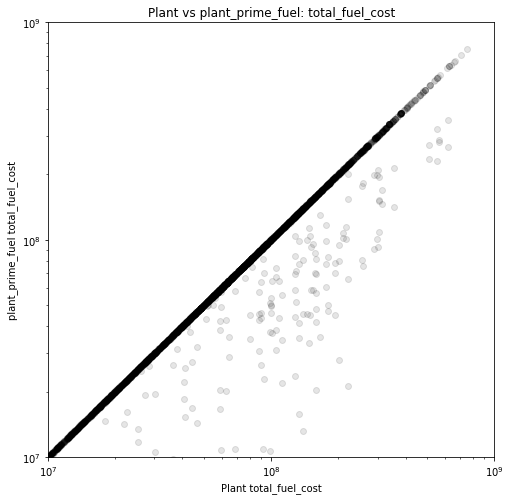

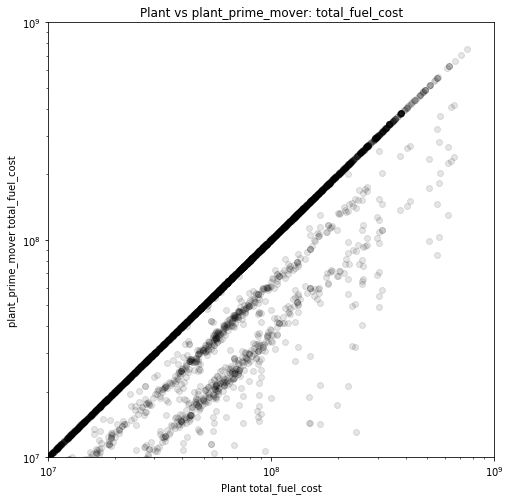

In [12]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    #'opex_fuel',
    'net_generation_mwh',
    'total_mmbtu',
    # Derived values
    #'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
    'total_fuel_cost'
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (1e0, 1e4),
    'net_generation_mwh': (1e3,1e8),
    'total_mmbtu': (1e4,1e9),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (1e0,1e1),
    'total_fuel_cost': (1e7,1e9)
}

for field in fields_to_plot:
    plot_plant_vs_agg(compiled_plant_parts,field, xy_limits, scale="log")

In [13]:
def plot_gens_vs(compiled_plant_parts,part_name, data_col, weight_col, x_range):
    gen_df = compiled_plant_parts['plant_gen'][compiled_plant_parts['plant_gen'][data_col] != 0]
    part_df = compiled_plant_parts[part_name][compiled_plant_parts[part_name][data_col] != 0]
    if weight_col:
        weights_gen = gen_df[weight_col]
        weights_part = part_df[weight_col]
    else:
        weights_gen = None
        weights_part = None

    plt.hist(gen_df[data_col], 
             weights=weights_gen,
             range=x_range,
             bins=100,
             color="purple", #alpha=test_alpha,
             label="Generators")

    plt.hist(part_df[data_col], 
             weights=weights_part,
             range=x_range,
             bins=100,
             color="black",
             label=f'{part_name}')

    plt.title(f'Gens vs. {part_name}: {data_col}')
    plt.xlabel(data_col)
    plt.ylabel(None)
    plt.legend()
    plt.show()

In [14]:
x_ranges = {
    'capacity_mw' : (0,400),
    'net_generation_mwh': (0, 2500000),
    'fuel_cost_per_mmbtu': (0, 5),
    'fuel_cost_per_mwh': (0, 100),
    'total_fuel_cost': (0,200000000)
}

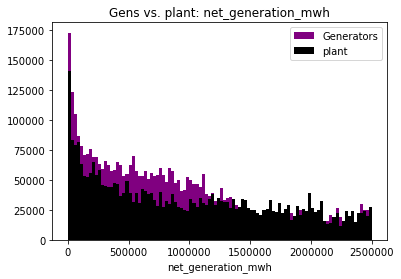

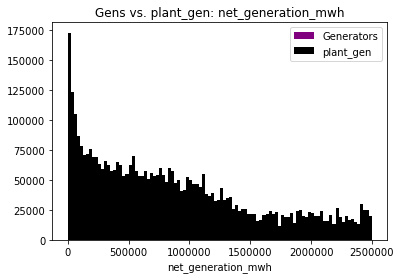

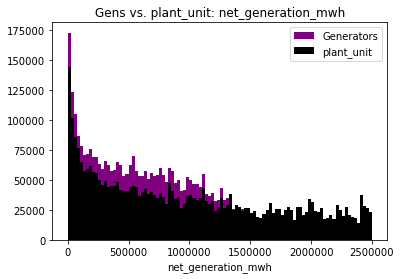

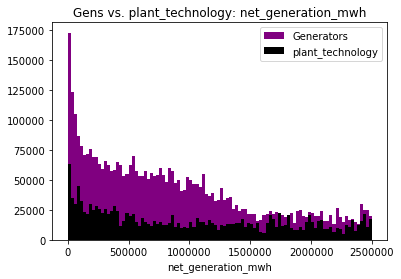

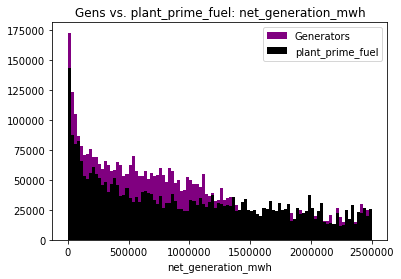

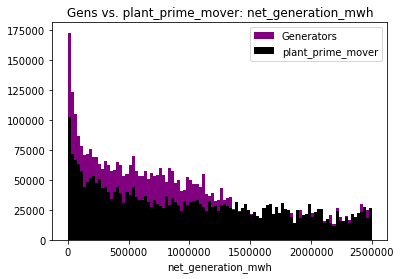

In [15]:
for part_name in compiled_plant_parts.keys():
    data_col =  'net_generation_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

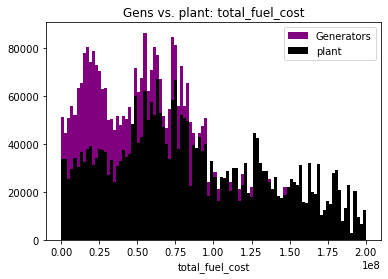

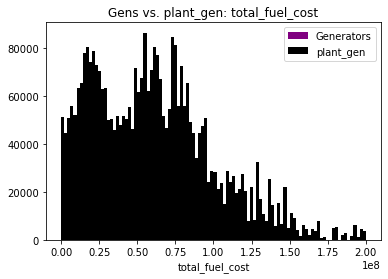

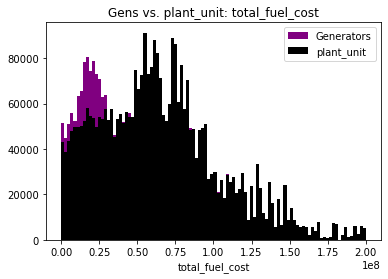

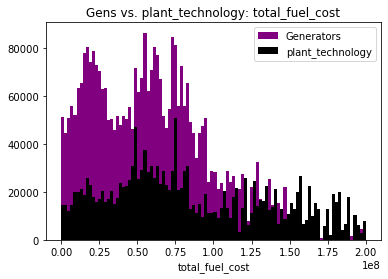

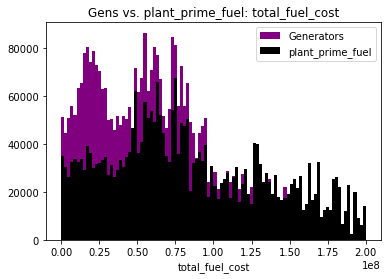

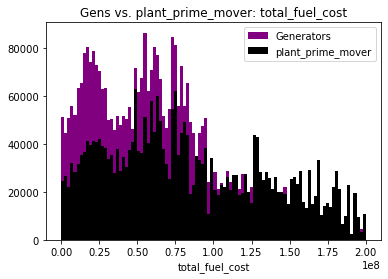

In [16]:
for part_name in compiled_plant_parts.keys():
    data_col =  'total_fuel_cost'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


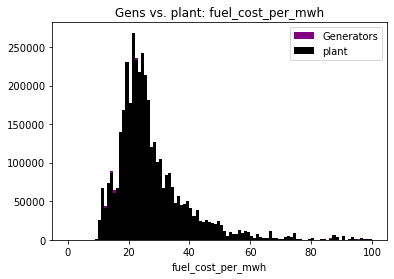

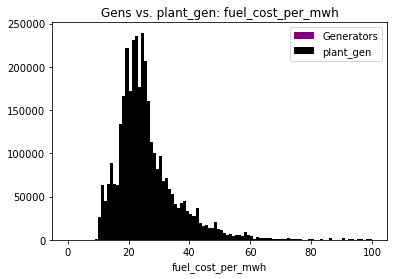

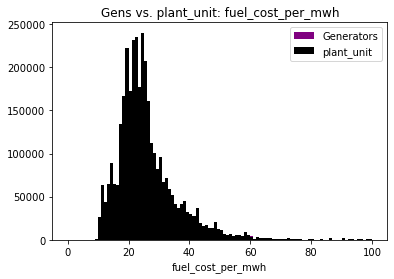

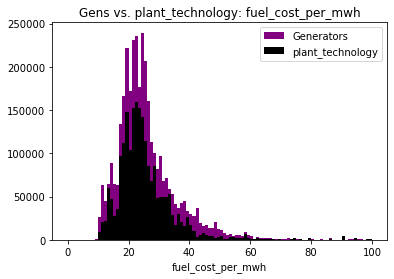

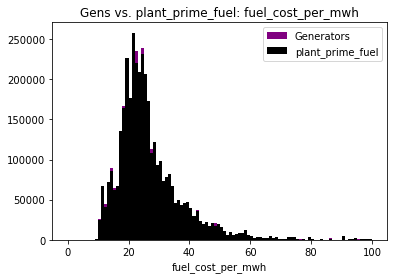

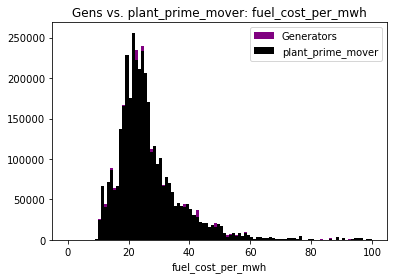

In [17]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

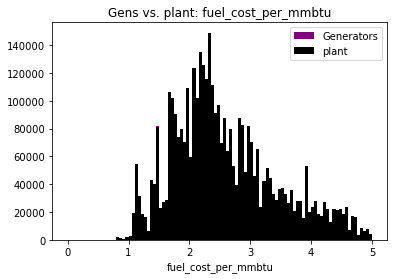

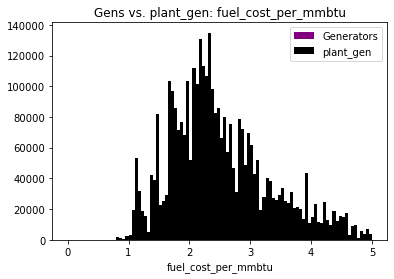

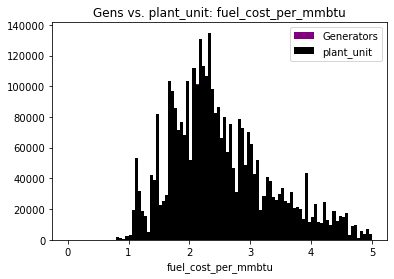

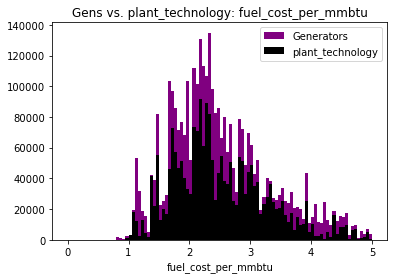

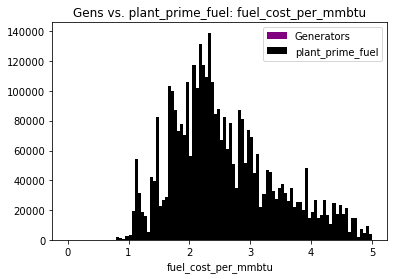

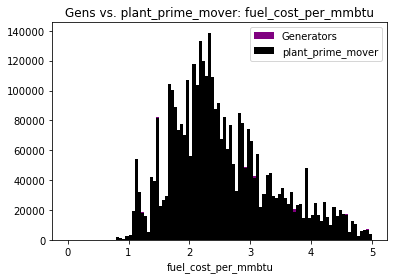

In [18]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mmbtu'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

## Playing with the compiled outputs 

In [19]:
# various tables to poke at for debuging
generat923 = self.grab_the_table('generation_eia923')
gens860 = self.grab_the_table('generators_eia860')
bga860 = self.grab_the_table('boiler_generator_assn_eia860')
own860 = self.grab_the_table('ownership_eia860')
plant = compiled_plant_parts['plant']
plant_gen = compiled_plant_parts['plant_gen']
plant_unit = compiled_plant_parts['plant_unit']
plant_fuel = compiled_plant_parts['plant_prime_fuel']
plant_tech = compiled_plant_parts['plant_technology']
plant_pm = compiled_plant_parts['plant_prime_mover']

In [20]:
# this can be used to see if the aggregations generally worked properly
plant_gen_agged = plant_gen.groupby(by=['utility_id_eia','plant_id_eia','fraction_owned','report_date']).sum().reset_index()
merge = plant.merge(plant_gen_agged,
                    on=['utility_id_eia','plant_id_eia','fraction_owned','report_date'],
                    suffixes=('_plant','_gen')).drop(columns=['fuel_cost_per_mmbtu_plant','fuel_cost_per_mmbtu_gen',
                                                              'heat_rate_mmbtu_mwh_plant', 'heat_rate_mmbtu_mwh_gen',
                                                              'fuel_cost_per_mwh_plant','fuel_cost_per_mwh_gen',
                                                             ])

In [21]:
count_df = pd.DataFrame(index=list(compiled_plant_parts['plant'].columns))
for k,cpp_df in compiled_plant_parts.items():
    count_df = count_df.merge(
        pd.DataFrame(cpp_df[cpp_df['report_date'].dt.year == 2017]
                     .count(), columns=[k]),
        right_index=True, left_index=True)
count_df = count_df.merge(pd.DataFrame(count_df.sum(axis=1),columns=['total']),
                          right_index=True, left_index=True)

In [22]:
count_df

,plant,plant_gen,plant_unit,plant_technology,plant_prime_fuel,plant_prime_mover,total
fraction_owned,12425,31117,3294,13638,13364,14204,88042
utility_id_eia,12425,31117,3294,13638,13364,14204,88042
plant_id_eia,12425,31117,3294,13638,13364,14204,88042
report_date,12425,31117,3294,13638,13364,14204,88042
fuel_cost_per_mmbtu,830,1891,1395,862,849,1046,6873
heat_rate_mmbtu_mwh,830,1891,1395,862,849,1046,6873
fuel_cost_per_mwh,830,1891,1395,862,849,1046,6873
total_fuel_cost,12425,31117,3294,13638,13364,14204,88042
net_generation_mwh,12425,31117,3294,13638,13364,14204,88042
capacity_mw,12425,31117,3294,13638,13364,14204,88042


In [33]:
gen923 = self.grab_the_table('generation_eia923')

In [ ]:
gen923.drop_duplicates